<h1>Open haloscope</h1>

<h4>Imports</h4>

In [1]:
import sys, os
import time

import numpy as np
from scipy.signal import periodogram, welch

import matplotlib.pyplot as plt
# plot options
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size=14)

In [2]:
import lib.open_haloscope.experiment as experiment
from lib.open_haloscope.utils import OHUtils

In [3]:
haloscope_name = 'kakapo_haloscope'
haloscope_json = OHUtils.load_experiment_json(haloscope_name)

H = experiment.FermionicHaloscope(haloscope_json)

In [4]:
from lib.red.redpitaya_qcodes import Redpitaya
red = Redpitaya('redpitaya', address=H.experiment_parameters['redpitaya_eth0_ip'])

Connected to: REDPITAYA INSTR2020 (serial:0, firmware:01-02) in 0.37s


<h4>Test of the drivers</h4>

In [5]:
H.experiment_parameters

{'_parameters_Kakapo': 'Parameters used in the fermionic haloscope Kakapo',
 'f0': 2000000.0,
 'Q': 100,
 'An': 1e-08,
 'Ap': 1.0,
 'beta1': 1,
 'beta2': 1,
 'operating_frequency': 'MHz',
 'material_used': 'NiZn ferrite',
 'redpitaya_eth0_ip': 'TCPIP::169.254.33.148::5000::SOCKET',
 'redpitaya_wlan_ip': 'TCPIP::192.168.1.30::5000::SOCKET'}

In [13]:
H.initialise_haloscope([red])

Loading instrumentation
  redpitaya added to the experiment

Setup the radiofrequency lines
 inputs configured, trigger level = 0.0 V, decimation = 4
 resulting sampling frequency = 31.25 MHz
 output generators triggered, phase aligned and turned off

Starting UART communication
 testing sensors
 temperature = 301.58 K
 pressure = 1.1056 bar
 magnetic field = -4687.5 mT
 photoresistance = 0.9326171875 Ohm
 acceleration = (0.0, -0.82, 10.47) m/s^2

Haloscope initialised. Good luck, dark matter hunter.


<h3>VNA</h3>

In [7]:
red.vna_start(0.1e6)
red.vna_stop(20e6)
red.vna_points(1001)
red.vna_rbw(10e3)

red.vna_amplitude(0.001)
red.vna_averages(10)

In [8]:
mag1, phase1 = red.VNA1()
mag2, phase2 = red.VNA2()

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [05:08<00:00,  3.25it/s]


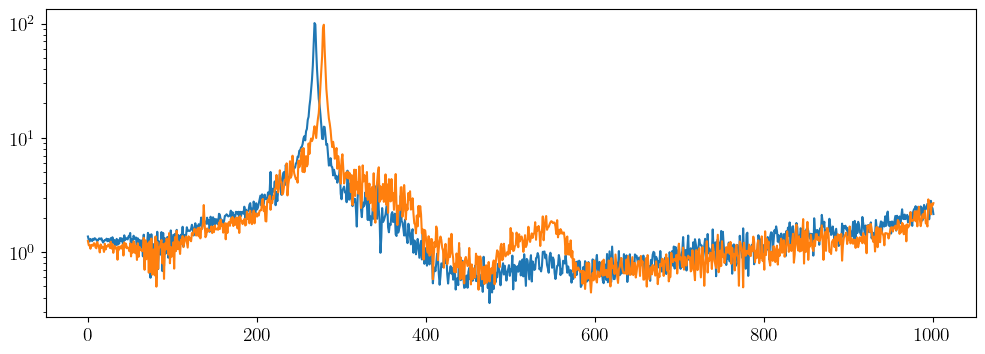

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.semilogy(mag1)
ax.semilogy(mag2)

<h3>Waveforms</h3>

In [19]:
# settings
# gen 1
red.OUT1_amplitude(1)
red.OUT1_frequency(5e6)
red.OUT1_status('ON')

# gen 2
red.OUT2_amplitude(0.01)
red.OUT2_frequency(2e5)
red.OUT2_status('OFF')

In [20]:
# adc parameters
fs = H.sampling_frequency

In [21]:
# acquisition
red.acquisition_length(10)
data = red.IN1()

101it [00:10,  9.96it/s]                                                                                               


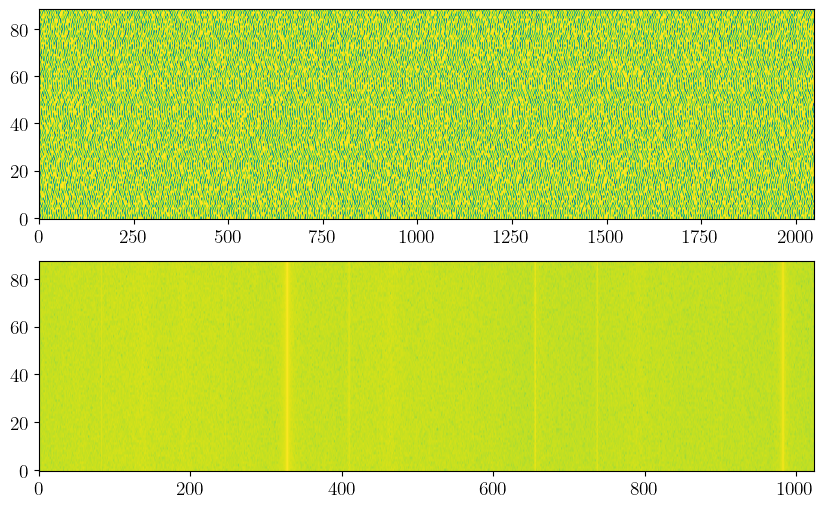

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
n_start = 1
n_stop = 2**11

ax[0].imshow( data[:,n_start:n_stop], aspect='auto', origin='lower' )
ax[1].imshow( np.log10(periodogram( data[:,n_start:n_stop] )[1][1:]), aspect='auto', origin='lower' )

#ax[1].set_ylim([1e-8,1])

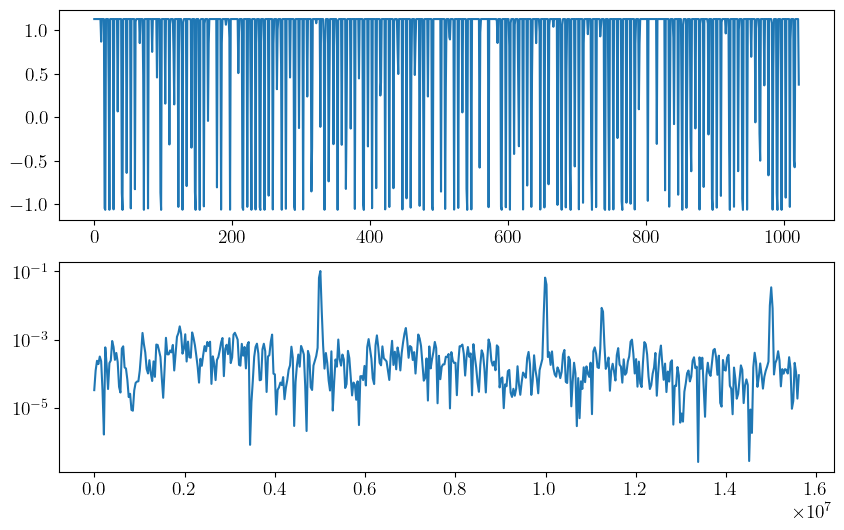

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
n_start = 1
n_stop = 2**10
num = 0

ax[0].plot(data[num, n_start:n_stop])

f = periodogram(data[num, n_start:n_stop], fs=fs)[0]
rbw = f[1] - f[0]
m = rbw * periodogram(data[num, n_start:n_stop], window='hann', fs=fs)[1]
ax[1].semilogy(f, m)

In [29]:
red.estimated_duty_cycle()

0.0046137344